# 1. *Installation*

In [ ]:
%pip install nrclex
%pip install transformers torch pandas matplotlib seaborn
import nltk
nltk.download('punkt')


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 

import pandas as pd
from nrclex import NRCLex
import re

# Load your CSV
file_path = r'D:\datathone_project\aba_output_with_scores.csv'
df = pd.read_csv(file_path)

# Features and their associated keywords
aspect_keywords = {
    1: ('Battery Life', ['battery', 'charge', 'charging']),
    2: ('Sound Quality', ['sound', 'audio', 'bass', 'treble']),
    3: ('Comfort/Fit', ['fit', 'comfort', 'comfortable', 'ear']),
    4: ('Build Quality / Durability', ['build', 'durable', 'durability', 'broke', 'quality']),
    5: ('Design / Shape / Style', ['design', 'shape', 'style', 'look', 'appearance']),
    6: ('Price / Value for Money', ['price', 'cost', 'value', 'expensive', 'cheap']),
    7: ('Controls / Touch Functionality', ['controls', 'buttons', 'touch', 'tap']),
}

# Preprocess reviews (to lowercase for matching)
df['cleaned_text'] = df['text'].fillna('').str.lower()

# Initialize a dictionary to hold results
feature_emotion_stats = {}

# Function to identify emotions in text using NRCLex
def get_emotions_from_text(text):
    emotion_counts = {}
    emo = NRCLex(text).top_emotions  # List of tuples like [('anger', 0.5), ('sadness', 0.25), ...]
    for emotion, _ in emo:
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    return emotion_counts

# Analyze emotions by feature
for feature_id, (feature_name, keywords) in aspect_keywords.items():
    # Find reviews that mention the feature keywords
    keyword_reviews = df[df['cleaned_text'].apply(lambda x: any(keyword in x for keyword in keywords))]
    
    emotion_counts = {}
    
    # For each review mentioning the feature, extract emotions
    for review in keyword_reviews['cleaned_text']:
        emotions_in_review = get_emotions_from_text(review)
        for emotion, count in emotions_in_review.items():
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + count
    
    # Calculate the percentage of each emotion for the feature
    total_emotions = sum(emotion_counts.values())
    if total_emotions > 0:
        emotion_percentages = {emotion: round(count / total_emotions * 100, 2) for emotion, count in emotion_counts.items()}
    else:
        emotion_percentages = {}
    
    # Store the result in the dictionary
    feature_emotion_stats[feature_name] = emotion_percentages

# Convert the results into a DataFrame for easier analysis
emotion_df = pd.DataFrame(feature_emotion_stats).fillna(0).T

# Display the results
print(emotion_df)

# Plot the results (emotion distribution per feature)
import matplotlib.pyplot as plt

emotion_df.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='tab10')
plt.title('Emotion Distribution by Feature')
plt.ylabel('Percentage')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()


AttributeError: module 'textblob' has no attribute 'download_corpora'

In [20]:
def compute_average_emotion_score(val):
    try:
        if pd.isna(val):
            return None
        scores = [int(s.strip()) for s in str(val).split(',') if s.strip().isdigit()]
        if scores:
            return sum(scores) / len(scores)
        else:
            return None
    except:
        return None

# Apply function to the Emotion_Score column
df['Average_Emotion_Score'] = df['Emotion_Score'].apply(compute_average_emotion_score)
df.to_csv(r'D:\datathone_project\aba_with_avg_emotion.csv', index=False)

# 2. *Emotion Analysis of Customer Reviews with Hugging Face Pipeline*

Device set to use cpu


Classifying emotions...


100%|██████████| 2240/2240 [02:12<00:00, 16.86it/s]
C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\3911220648.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_emotions.index, y=top_emotions.values, palette="pastel")


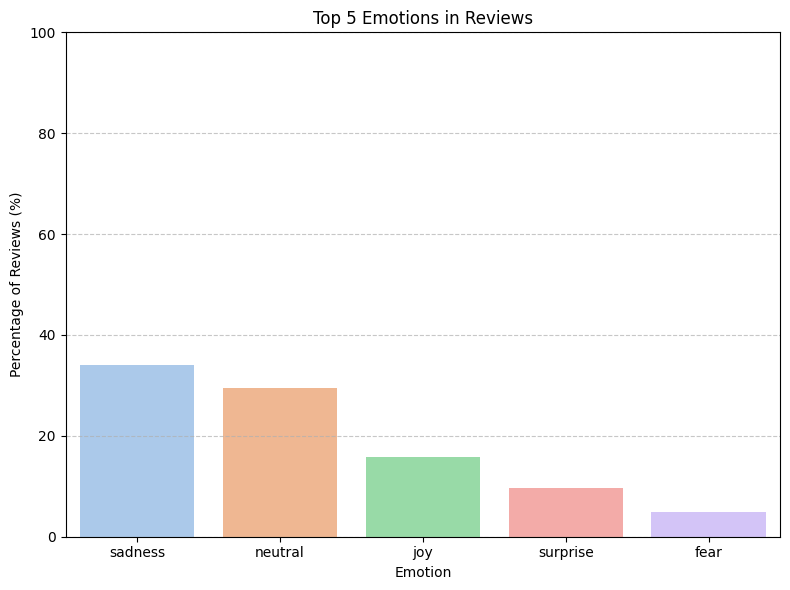

emotion
sadness     34.062500
neutral     29.508929
joy         15.848214
surprise     9.732143
fear         4.955357
Name: proportion, dtype: float64


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm

# Initialize emotion classifier
emotion_classifier = pipeline("text-classification", 
                              model="j-hartmann/emotion-english-distilroberta-base", 
                              return_all_scores=False)

# Emotion detection function
def detect_emotions(reviews):
    emotions = []
    print("Classifying emotions...")
    for review in tqdm(reviews):
        try:
            # Truncate input to first 512 characters
            truncated_review = review[:512]
            result = emotion_classifier(truncated_review)[0]
            emotions.append(result['label'])
        except Exception as e:
            print(f"Error with review: {review[:100]}... -> {e}")
            emotions.append("error")
    return emotions

# Main analysis function
def analyze_emotions(csv_path, text_column="cleaned_text"):
    # Load data
    df = pd.read_csv(csv_path)

    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in CSV.")

    # Detect emotions
    df['emotion'] = detect_emotions(df[text_column].astype(str).tolist())

    # Filter out errors if any
    df = df[df['emotion'] != "error"]

    # Count emotion percentages
    emotion_counts = df['emotion'].value_counts(normalize=True) * 100
    top_emotions = emotion_counts.head(5)

    # Plot emotion distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_emotions.index, y=top_emotions.values, palette="pastel")
    plt.title("Top 5 Emotions in Reviews")
    plt.ylabel("Percentage of Reviews (%)")
    plt.xlabel("Emotion")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df, top_emotions

# Example usage
# Replace the path with your actual CSV file path
csv_file_path = r"D:\datathone_project\aba_output_with_scores.csv"
result_df, emotion_summary = analyze_emotions(csv_file_path)

# Optional: print emotion summary
print(emotion_summary)


# 3. *📌 Customer Review Emotion Detection & Analysis using Hugging Face* 

Device set to use cpu
c:\Users\Divy\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




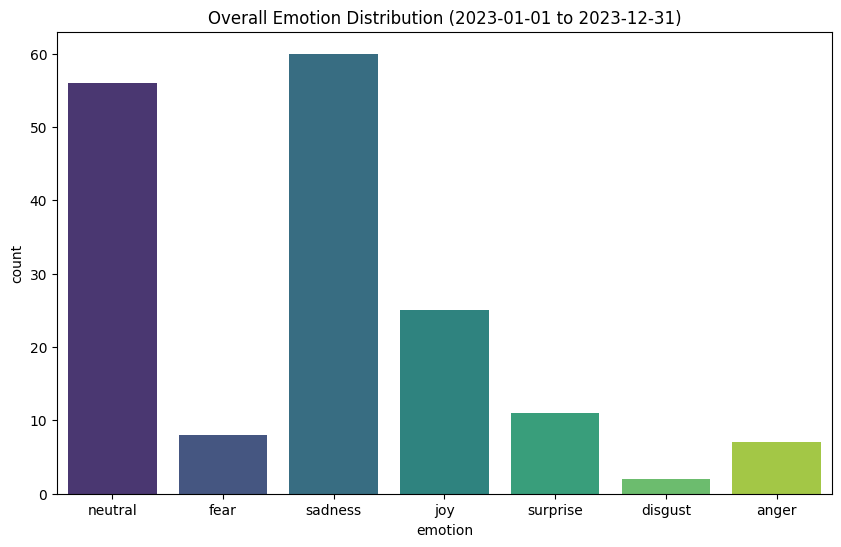

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




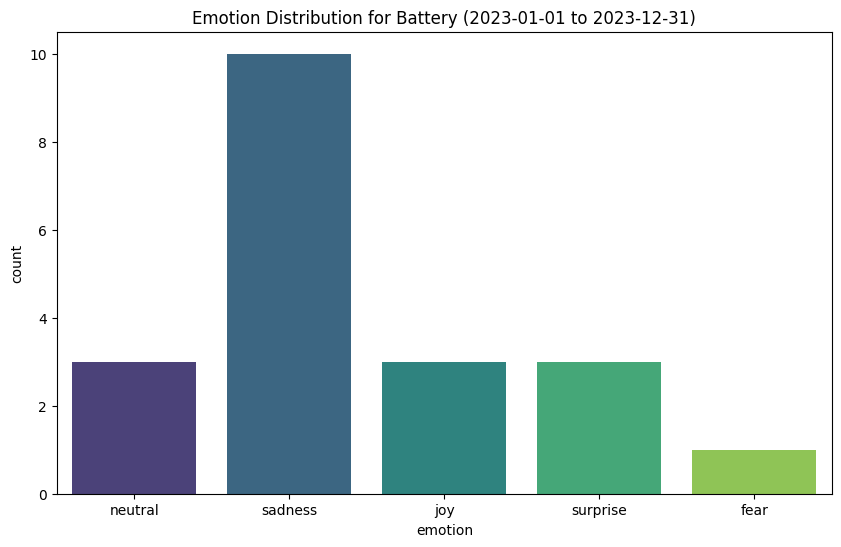

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




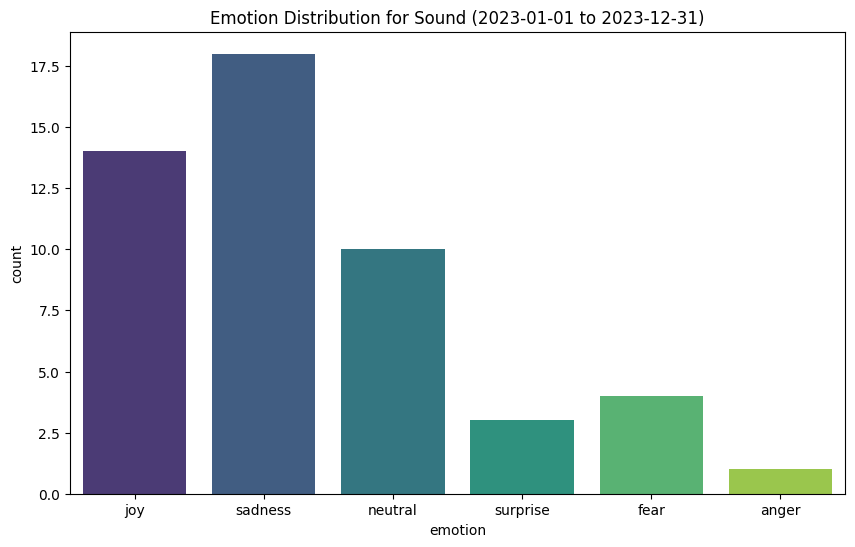

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




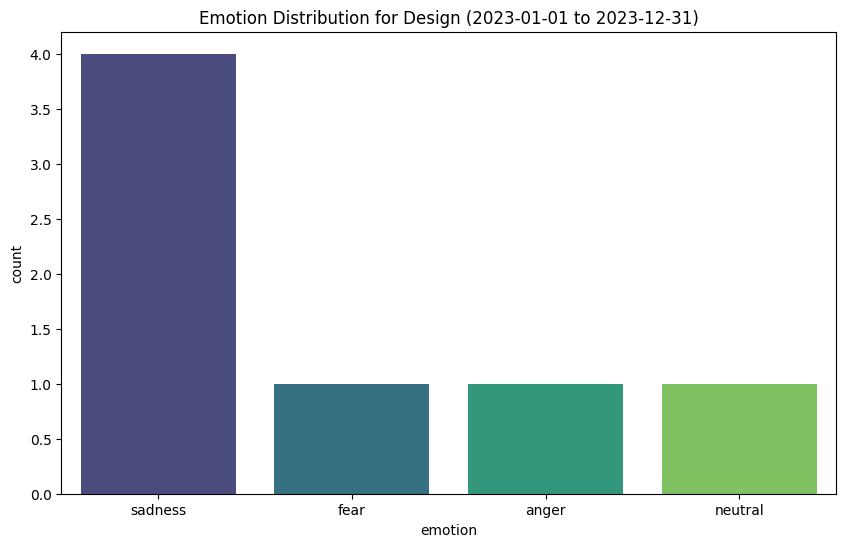

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




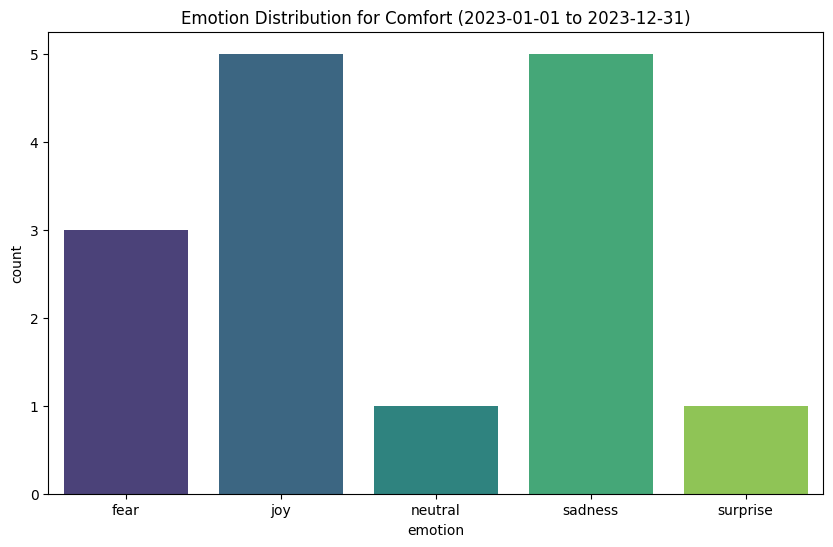

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




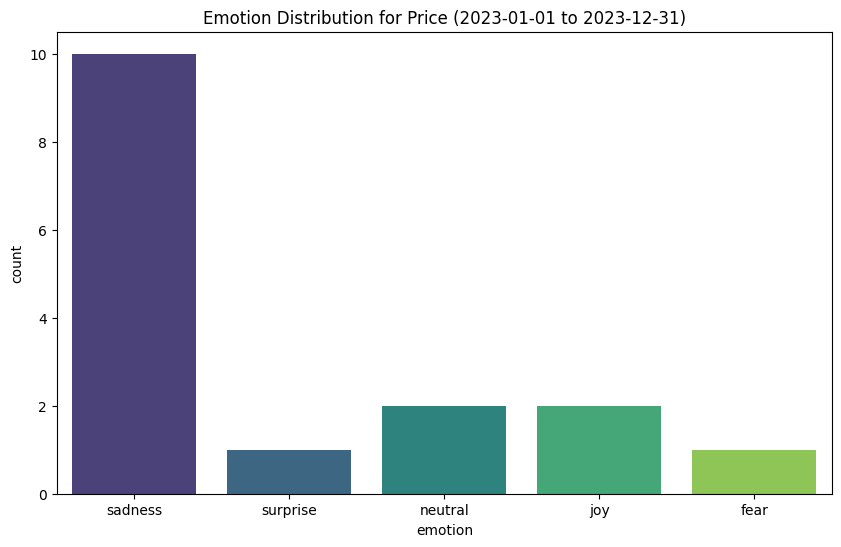

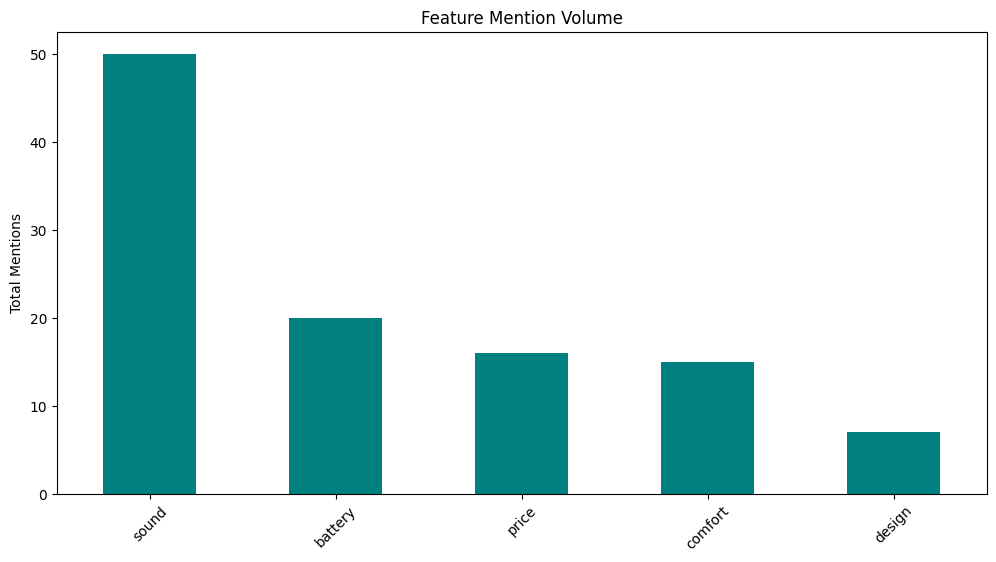

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\1106209713.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




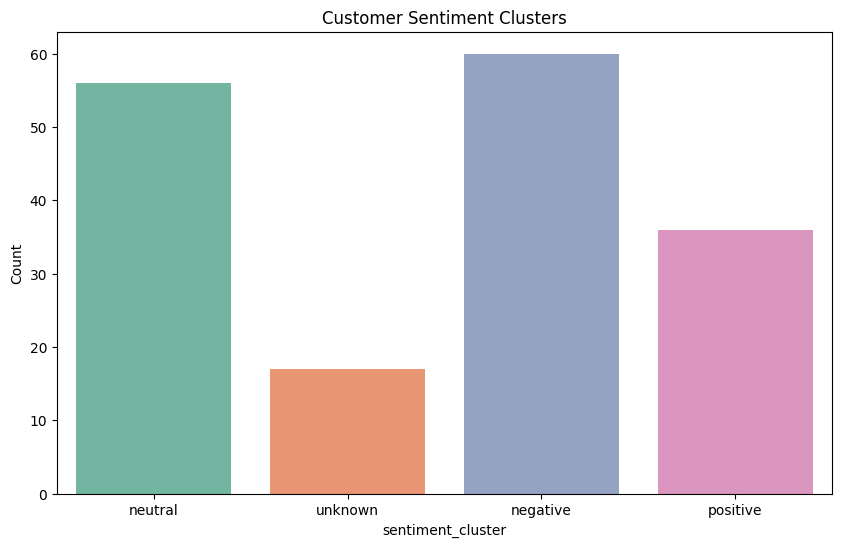

✅ Analysis Complete!


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import matplotlib.dates as mdates
import seaborn as sns

# Step 1: Load data
file_path = r"D:\datathone_project\aba_output_with_scores.csv"
df = pd.read_csv(file_path)

# Step 2: Convert timestamp
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float) / 1000, unit='s')
except Exception as e:
    print(f"Error converting timestamp: {e}")

# Step 3: Define emotion detection function
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=False)

def detect_emotion(text):
    try:
        # Truncate long reviews to 512 tokens (approx 3000 characters)
        return classifier(text[:512])[0]['label']
    except Exception as e:
        print(f"Error on text: {text[:50]}... -> {e}")
        return "neutral"

df['emotion'] = df['cleaned_text'].astype(str).apply(detect_emotion)

# Step 4: Map emotions to scores
emotion_map = {'sadness': 1, 'neutral': 2, 'joy': 3, 'surprise': 4}
df['emotion_score'] = df['emotion'].map(emotion_map).fillna(0)

# Step 5: Extract features (simple keyword matching for now)
features = ['battery', 'sound', 'design', 'comfort', 'price']

for feature in features:
    df[feature] = df['cleaned_text'].astype(str).str.contains(feature, case=False, na=False).astype(int)

# === Time Range Filtering ===
start_date = '2023-01-01'
end_date = '2023-12-31'
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Step 6: Plot overall emotion distribution
plt.figure(figsize=(10, 6))
plt.title(f'Overall Emotion Distribution ({start_date} to {end_date})')
sns.countplot(data=df, x='emotion', palette='viridis')
plt.show()

# Step 7: Plot feature-wise emotion distribution
for feature in features:
    feature_df = df[(df[feature] == 1) & (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
    plt.figure(figsize=(10, 6))
    plt.title(f'Emotion Distribution for {feature.capitalize()} ({start_date} to {end_date})')
    sns.countplot(data=feature_df, x='emotion', palette='viridis')
    plt.show()

# === Step 8: Mention Volume Ranking ===
mention_counts = df[features].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
mention_counts.plot(kind='bar', color='teal')
plt.title('Feature Mention Volume')
plt.ylabel('Total Mentions')
plt.xticks(rotation=45)
plt.show()

# === Step 9: Emotion Clustering for Customer Segmentation ===
segment_map = {'positive': ['joy', 'surprise'], 'neutral': ['neutral'], 'negative': ['sadness']}
df['sentiment_cluster'] = df['emotion'].apply(lambda x: next((k for k, v in segment_map.items() if x in v), 'unknown'))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_cluster', palette='Set2')
plt.title('Customer Sentiment Clusters')
plt.ylabel('Count')
plt.show()

print("✅ Analysis Complete!")


# 4. *Cluster Customers based on  Emotion Profile*

Device set to use cpu
c:\Users\Divy\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\219959787.py:62: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




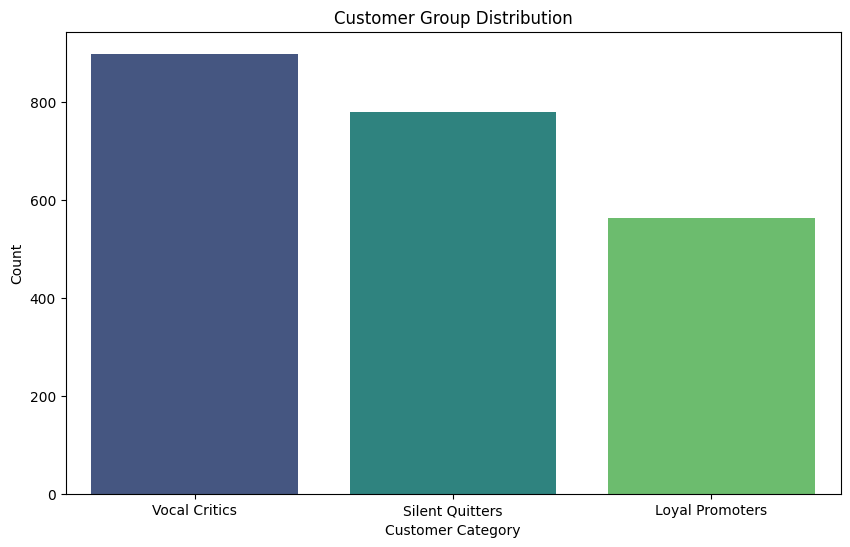

✅ Analysis Complete! CSV file updated with customer scores.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import seaborn as sns

# Load data
file_path = r"D:\datathone_project\aba_output_with_scores.csv"
df = pd.read_csv(file_path)

#  Convert timestamp
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float) / 1000, unit='s')
except Exception as e:
    print(f"Error converting timestamp: {e}")

#  Define emotion detection function
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=False)

def detect_emotion(text):
    try:
        # Truncate long reviews to 512 tokens (approx 3000 characters)
        return classifier(text[:512])[0]['label']
    except Exception as e:
        print(f"Error on text: {text[:50]}... -> {e}")
        return "neutral"

df['emotion'] = df['cleaned_text'].astype(str).apply(detect_emotion)

#  Map emotions and sentiments to scores
emotion_map = {'sadness': 1, 'neutral': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

def map_sentiment_score(star_rating):
    if 1.0 <= star_rating < 2.5:
        return 1  # Negative
    elif 2.5 <= star_rating < 3.5:
        return 2  # Neutral
    elif 3.5 <= star_rating <= 5.0:
        return 3  # Positive
    else:
        return 0  # Out of range or invalid

df['emotion_score'] = df['emotion'].map(emotion_map).fillna(0)
df['sentiment_score'] = df['vader_star_rating'].apply(map_sentiment_score)

df['customer_score'] = df['emotion_score'] + df['sentiment_score']

#  Categorize customers
conditions = [
    (df['customer_score'] >= 2) & (df['customer_score'] <= 3),  # Vocal Critics
    (df['customer_score'] > 3) & (df['customer_score'] <= 5),  # Silent Quitters
    (df['customer_score'] > 5)  # Loyal Promoters
]
categories = ['Vocal Critics', 'Silent Quitters', 'Loyal Promoters']  # Adjusted score ranges
df['customer_category'] = pd.cut(df['customer_score'], bins=[0, 3, 5, 8], labels=categories, include_lowest=True)

df.to_csv(r"D:\datathone_project\aba_output_with_customer_scores.csv", index=False)

# Plot customer group distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='customer_category', palette='viridis')
plt.title("Customer Group Distribution")
plt.xlabel("Customer Category")
plt.ylabel("Count")
plt.show()

print("✅ Analysis Complete! CSV file updated with customer scores.")


# 5. *Emotion Detection, Sentiment Scoring, and Feature Insights*

Device set to use cpu
c:\Users\Divy\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


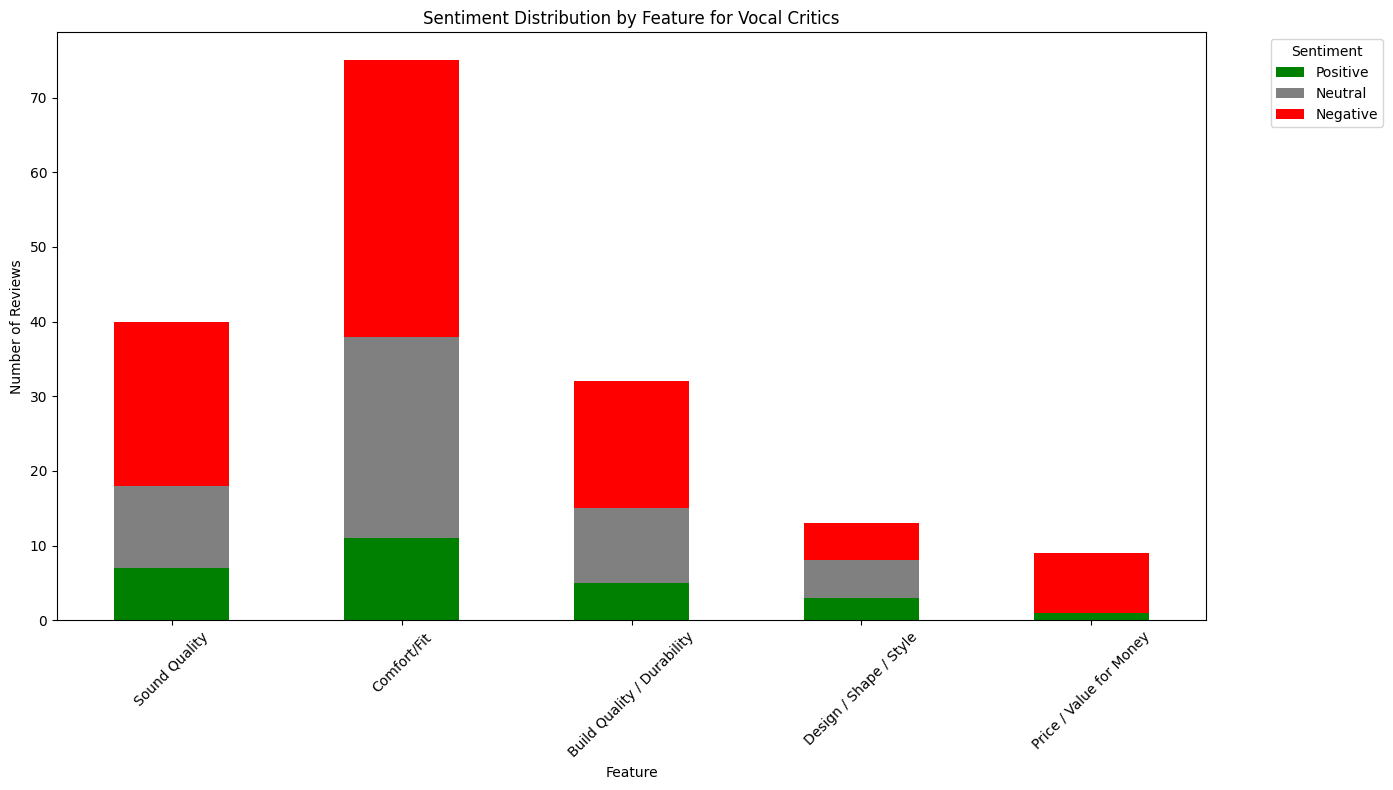

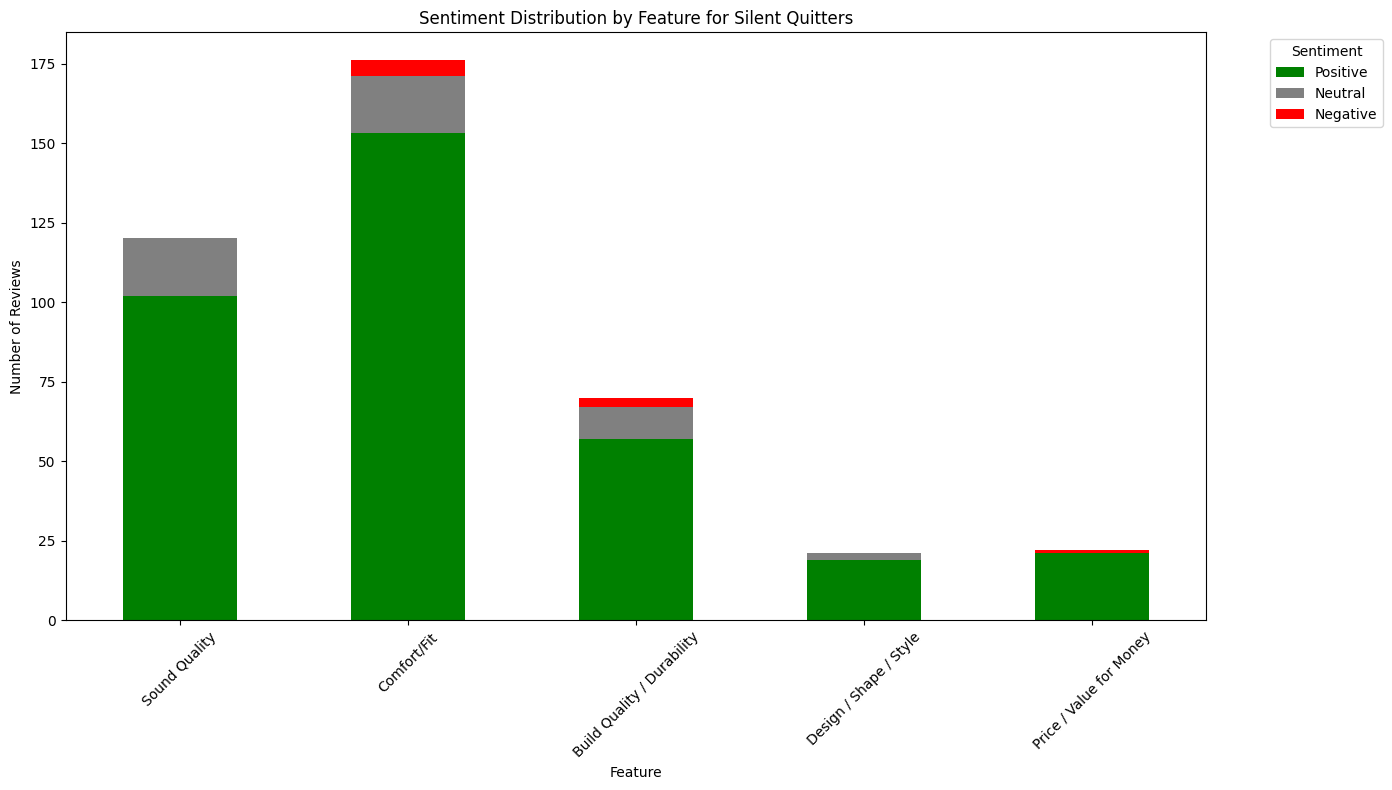

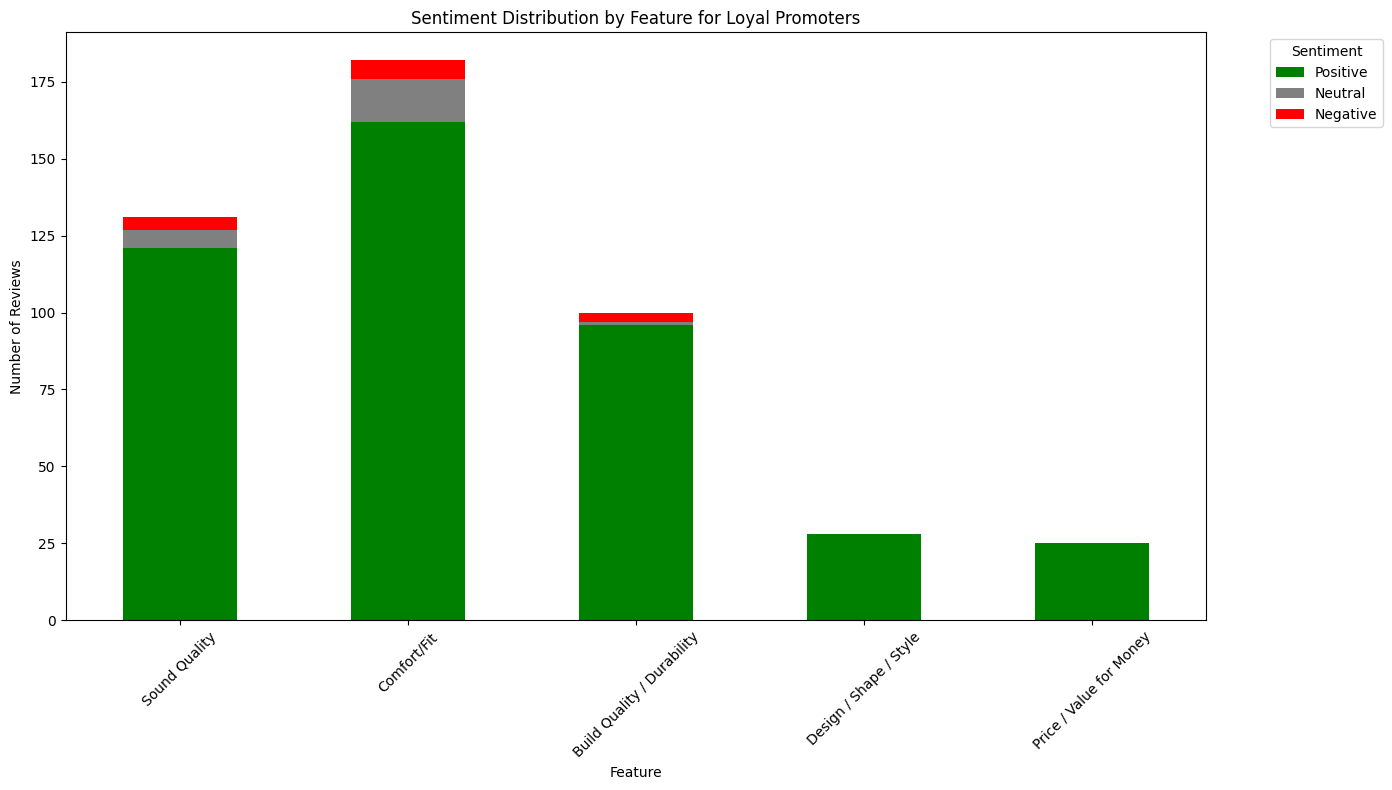

✅ Analysis Complete! CSV file updated with customer scores.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load data
file_path = r"D:\datathone_project\aba_output_with_scores.csv"
df = pd.read_csv(file_path)

#  Convert timestamp
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float) / 1000, unit='s')
except Exception as e:
    print(f"Error converting timestamp: {e}")

# Define emotion detection function
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=False)

def detect_emotion(text):
    try:
        # Truncate long reviews to 512 tokens (approx 3000 characters)
        return classifier(text[:512])[0]['label']
    except Exception as e:
        print(f"Error on text: {text[:50]}... -> {e}")
        return "neutral"

df['emotion'] = df['cleaned_text'].astype(str).apply(detect_emotion)

#  Map emotions and sentiments to scores
emotion_map = {'sadness': 1, 'neutral': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

def map_sentiment_score(star_rating):
    if 1.0 <= star_rating < 2.5:
        return 1  # Negative
    elif 2.5 <= star_rating < 3.5:
        return 2  # Neutral
    elif 3.5 <= star_rating <= 5.0:
        return 3  # Positive
    else:
        return 0  # Out of range or invalid

df['emotion_score'] = df['emotion'].map(emotion_map).fillna(0)
df['sentiment_score'] = df['vader_star_rating'].apply(map_sentiment_score)

df['customer_score'] = df['emotion_score'] + df['sentiment_score']

#  Categorize customers
conditions = [
    (df['customer_score'] >= 2) & (df['customer_score'] <= 3),  # Vocal Critics
    (df['customer_score'] > 3) & (df['customer_score'] <= 5),  # Silent Quitters
    (df['customer_score'] > 5)  # Loyal Promoters
]
categories = ['Vocal Critics', 'Silent Quitters', 'Loyal Promoters']  # Adjusted score ranges
df['customer_category'] = pd.cut(df['customer_score'], bins=[0, 3, 5, 8], labels=categories, include_lowest=True)

# Aspect Keyword Mapping
aspect_keywords = {
    
    2: ('Sound Quality', ['sound', 'audio', 'bass', 'treble']),
    3: ('Comfort/Fit', ['fit', 'comfort', 'comfortable', 'ear']),
    4: ('Build Quality / Durability', ['build', 'durable', 'durability', 'broke', 'quality']),
    5: ('Design / Shape / Style', ['design', 'shape', 'style', 'look', 'appearance']),
    6: ('Price / Value for Money', ['price', 'cost', 'value', 'expensive', 'cheap']),
    
}


def extract_features(row):
    features = []
    for num in str(row).replace(' ', '').split(','):
        try:
            features.append(aspect_keywords.get(int(num), ("Unknown", []))[0])
        except ValueError:
            pass  # Skip invalid entries
    return features

df['features_list'] = df['Feature_Number'].apply(extract_features)

#  Plotting for Each Customer Category
for category in categories:
    category_df = df[df['customer_category'] == category]
    feature_sentiment_counts = {key[0]: {'Positive': 0, 'Neutral': 0, 'Negative': 0} for key in aspect_keywords.values()}
    for idx, row in category_df.iterrows():
        features = row['features_list']
        sentiment = map_sentiment_score(row['vader_star_rating'])
        for feature in features:
            if sentiment == 3:
                feature_sentiment_counts[feature]['Positive'] += 1
            elif sentiment == 2:
                feature_sentiment_counts[feature]['Neutral'] += 1
            elif sentiment == 1:
                feature_sentiment_counts[feature]['Negative'] += 1

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(feature_sentiment_counts).T
    plot_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['green', 'grey', 'red'])
    plt.title(f"Sentiment Distribution by Feature for {category}")
    plt.xlabel("Feature")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("✅ Analysis Complete! CSV file updated with customer scores.")


# 6. *📌 Emotion-Driven Customer Segmentation and Feature-Level Sentiment Analysis of Reviews*

Device set to use cpu
c:\Users\Divy\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



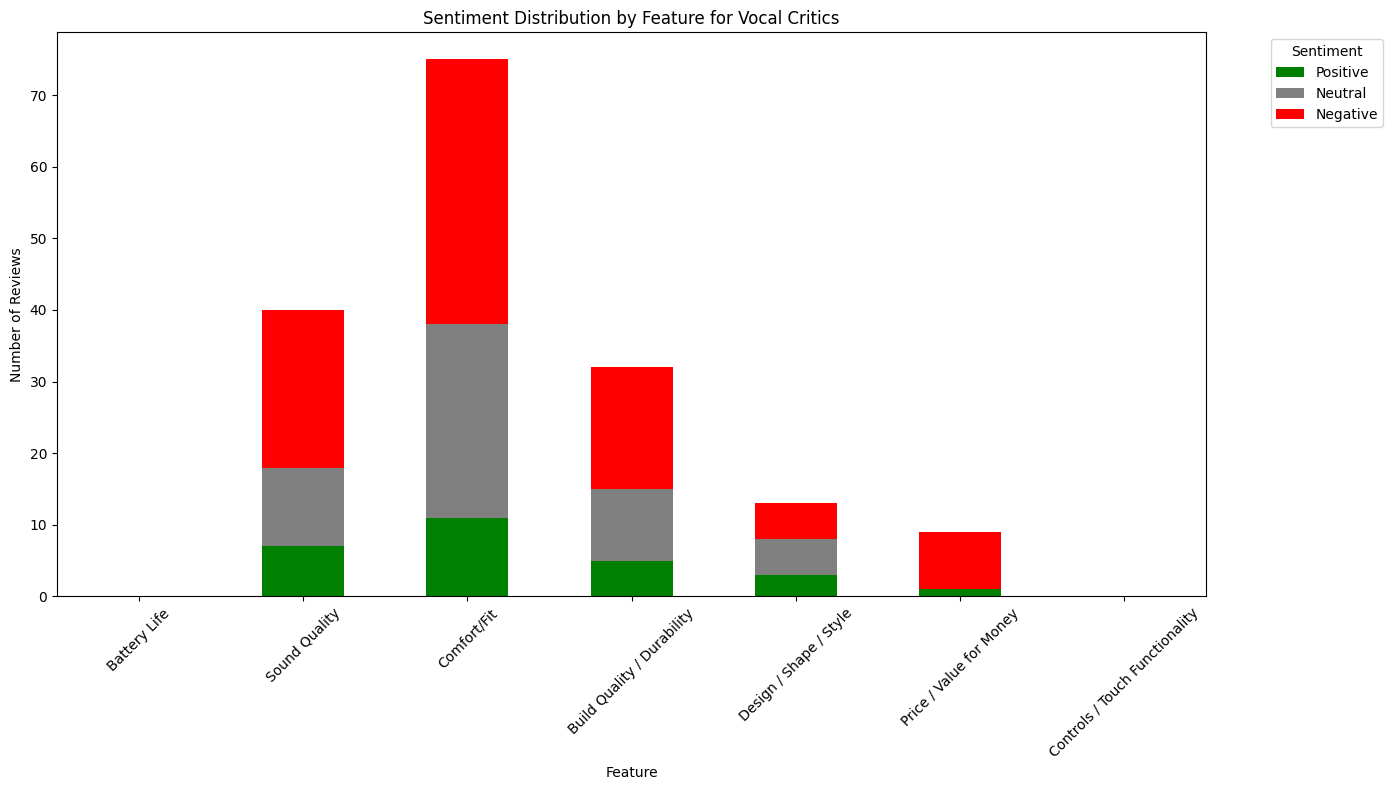

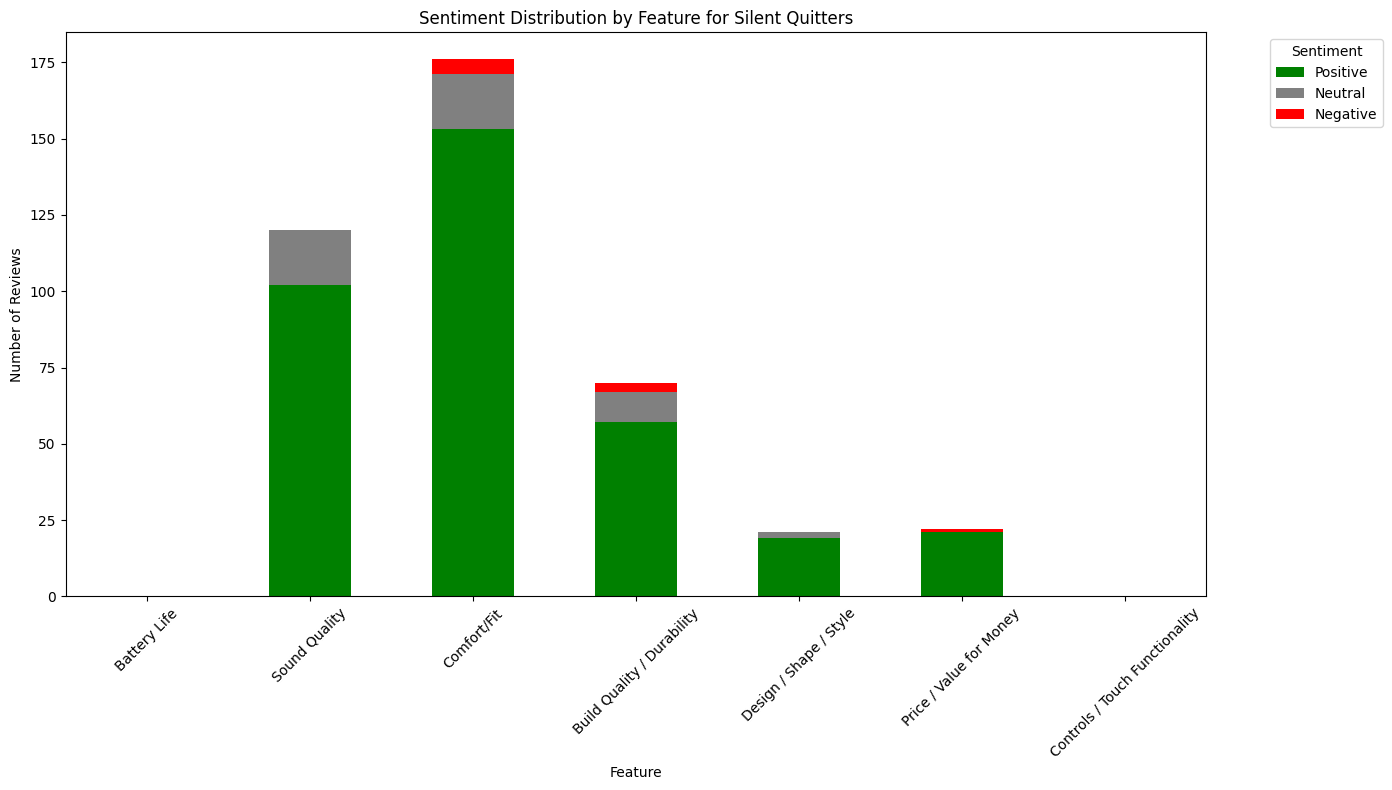

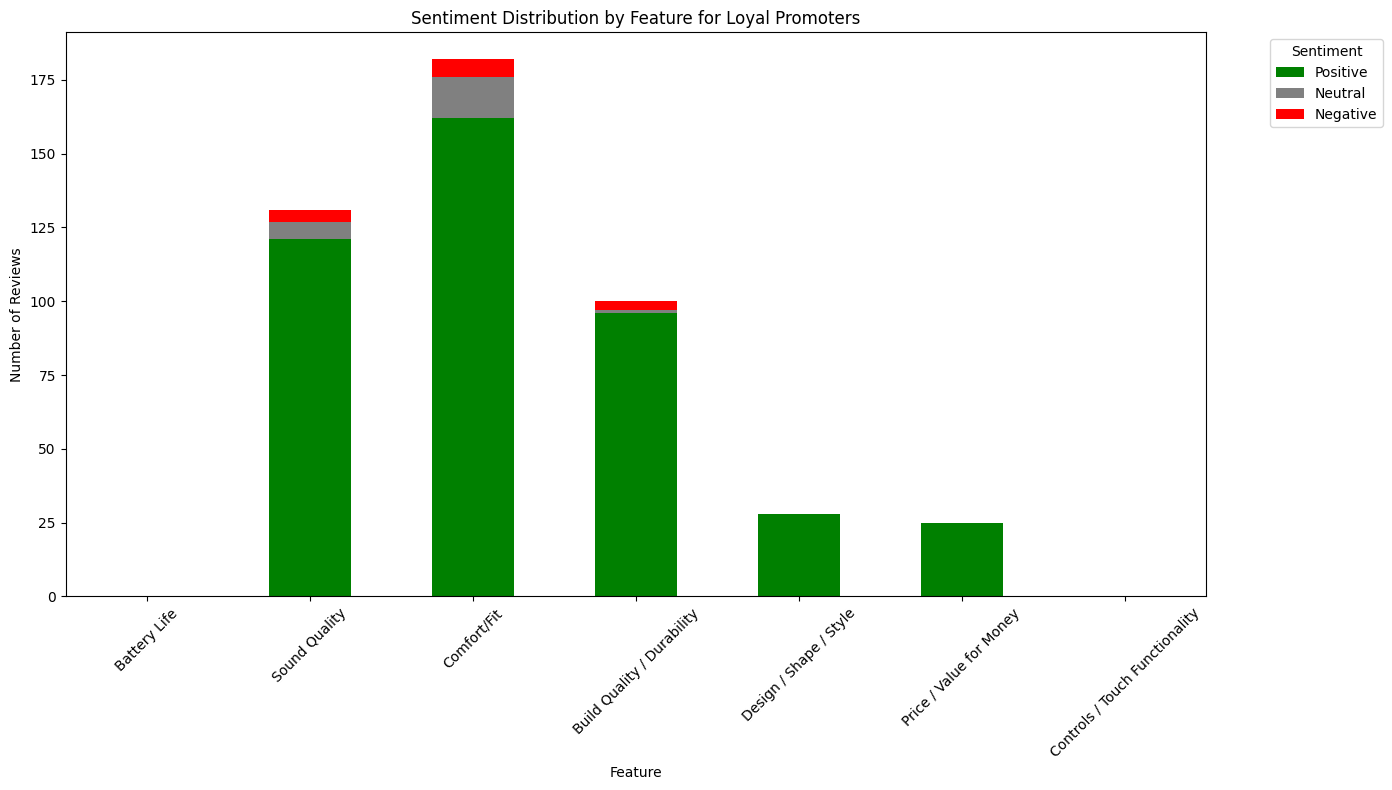

✅ Analysis Complete! CSV file updated with customer scores.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load data
file_path = r"D:\datathone_project\aba_output_with_scores.csv"
df = pd.read_csv(file_path)

# Convert timestamp
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float) / 1000, unit='s')
except Exception as e:
    print(f"Error converting timestamp: {e}")

#  Define emotion detection function
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=False)

def detect_emotion(text):
    try:
        # Truncate long reviews to 512 tokens (approx 3000 characters)
        return classifier(text[:512])[0]['label']
    except Exception as e:
        print(f"Error on text: {text[:50]}... -> {e}")
        return "neutral"

df['emotion'] = df['cleaned_text'].astype(str).apply(detect_emotion)

#  Map emotions and sentiments to scores
emotion_map = {'sadness': 1, 'neutral': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

def map_sentiment_score(star_rating):
    if 1.0 <= star_rating < 2.5:
        return 1  # Negative
    elif 2.5 <= star_rating < 3.5:
        return 2  # Neutral
    elif 3.5 <= star_rating <= 5.0:
        return 3  # Positive
    else:
        return 0  # Out of range or invalid

df['emotion_score'] = df['emotion'].map(emotion_map).fillna(0)
df['sentiment_score'] = df['vader_star_rating'].apply(map_sentiment_score)

df['customer_score'] = df['emotion_score'] + df['sentiment_score']

# Categorize customers
conditions = [
    (df['customer_score'] >= 2) & (df['customer_score'] <= 3),  # Vocal Critics
    (df['customer_score'] > 3) & (df['customer_score'] <= 5),  # Silent Quitters
    (df['customer_score'] > 5)  # Loyal Promoters
]
categories = ['Vocal Critics', 'Silent Quitters', 'Loyal Promoters']  # Adjusted score ranges
df['customer_category'] = pd.cut(df['customer_score'], bins=[0, 3, 5, 8], labels=categories, include_lowest=True)

#  Aspect Keyword Mapping
aspect_keywords = {
    1: ('Battery Life', ['battery', 'charge', 'charging']),
    2: ('Sound Quality', ['sound', 'audio', 'bass', 'treble']),
    3: ('Comfort/Fit', ['fit', 'comfort', 'comfortable', 'ear']),
    4: ('Build Quality / Durability', ['build', 'durable', 'durability', 'broke', 'quality']),
    5: ('Design / Shape / Style', ['design', 'shape', 'style', 'look', 'appearance']),
    6: ('Price / Value for Money', ['price', 'cost', 'value', 'expensive', 'cheap']),
    7: ('Controls / Touch Functionality', ['controls', 'buttons', 'touch', 'tap'])
}

def extract_features(row):
    features = []
    for num in str(row).replace(' ', '').split(','):
        try:
            features.append(aspect_keywords.get(int(num), ("Unknown", []))[0])
        except ValueError:
            pass  # Skip invalid entries
    return features

df['features_list'] = df['Feature_Number'].astype(str).apply(lambda x: [aspect_keywords.get(int(num), ("Unknown", []))[0] for num in x.split(',') if num.strip().isdigit()])

#  Plotting for Each Customer Category
for category in categories:
    category_df = df[df['customer_category'] == category]
    feature_sentiment_counts = {key[0]: {'Positive': 0, 'Neutral': 0, 'Negative': 0} for key in aspect_keywords.values()}
    for idx, row in category_df.iterrows():
        features = row['features_list']
        sentiment = map_sentiment_score(row['vader_star_rating'])
        for feature in features:
            if sentiment == 3:
                feature_sentiment_counts[feature]['Positive'] += 1
            elif sentiment == 2:
                feature_sentiment_counts[feature]['Neutral'] += 1
            elif sentiment == 1:
                feature_sentiment_counts[feature]['Negative'] += 1

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(feature_sentiment_counts).T
    plot_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['green', 'grey', 'red'])
    plt.title(f"Sentiment Distribution by Feature for {category}")
    plt.xlabel("Feature")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("✅ Analysis Complete! CSV file updated with customer scores.")


# 7. *visualization*

Device set to use cpu
c:\Users\Divy\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



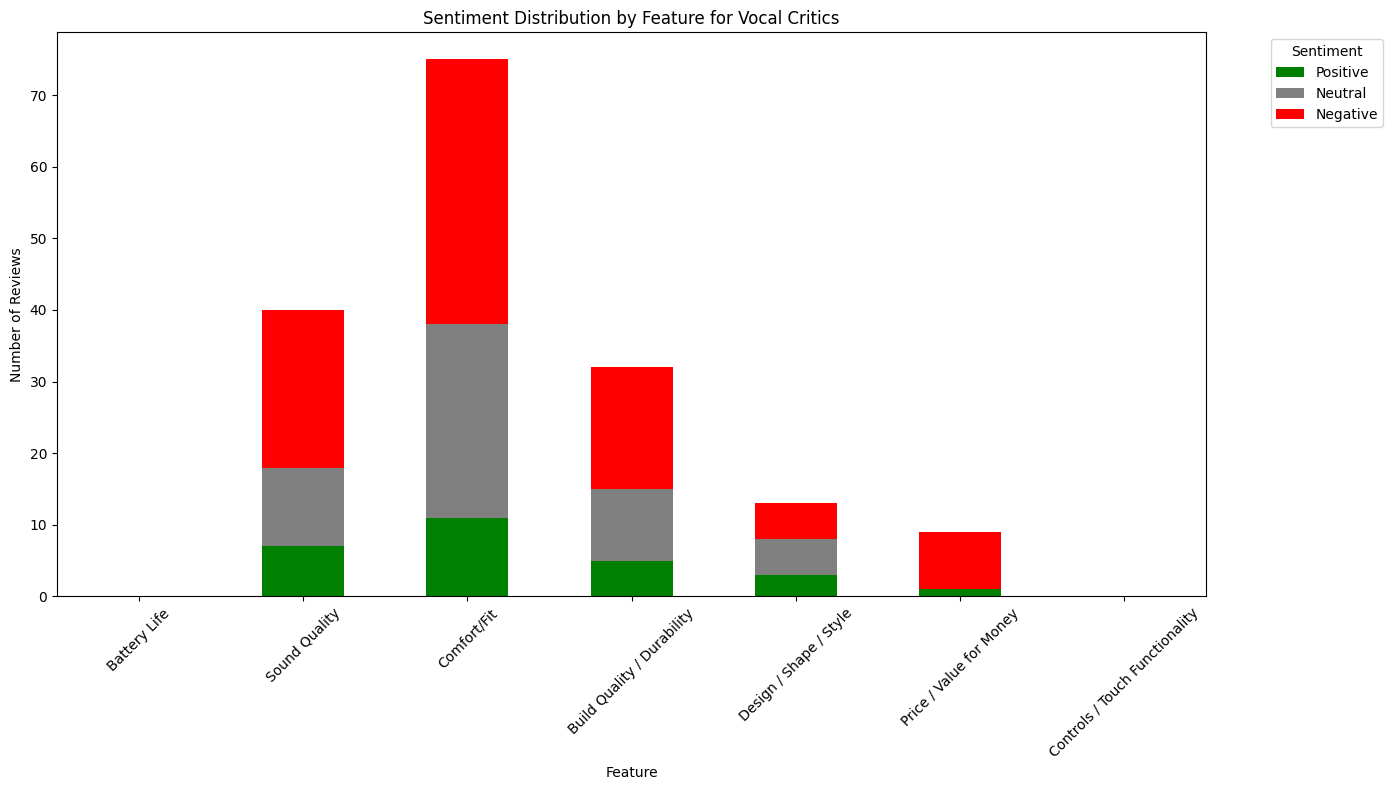

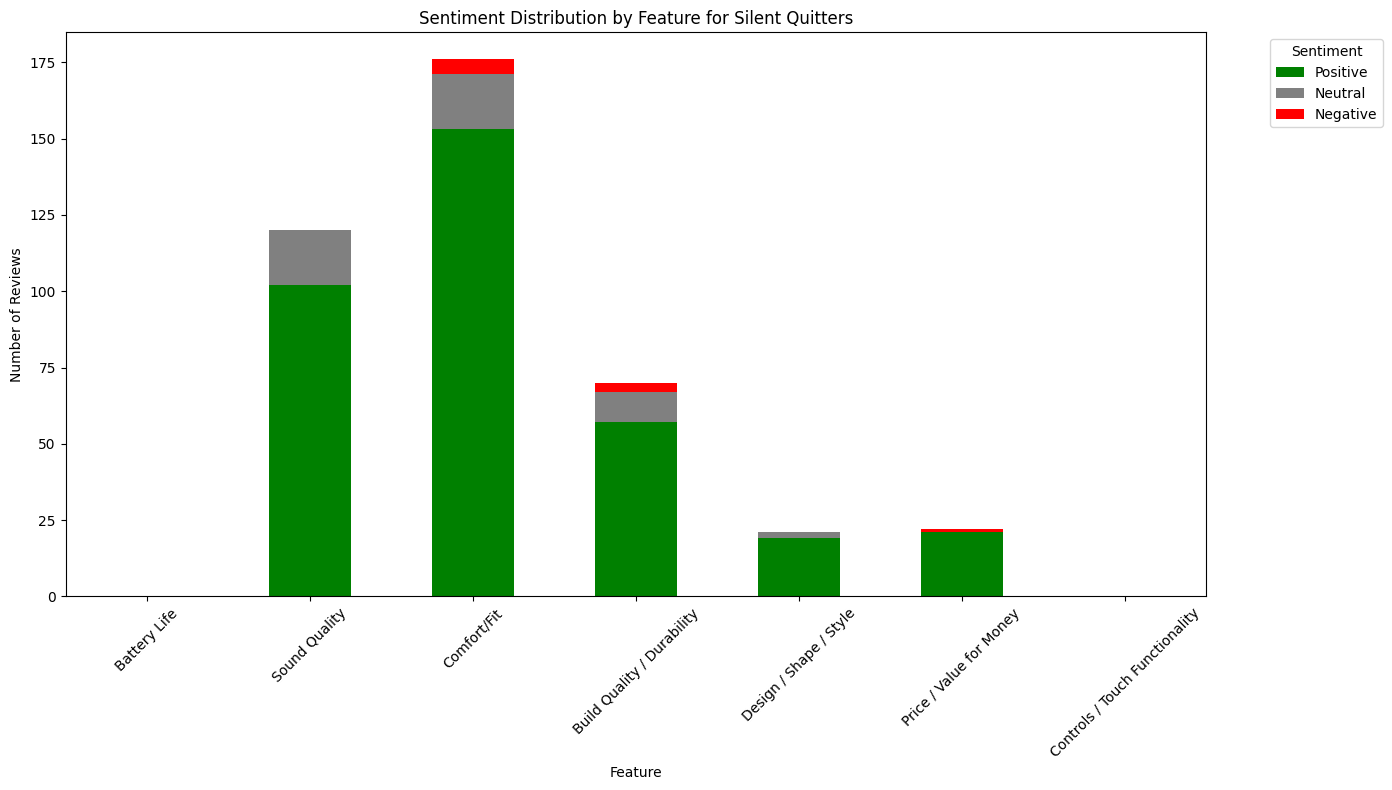

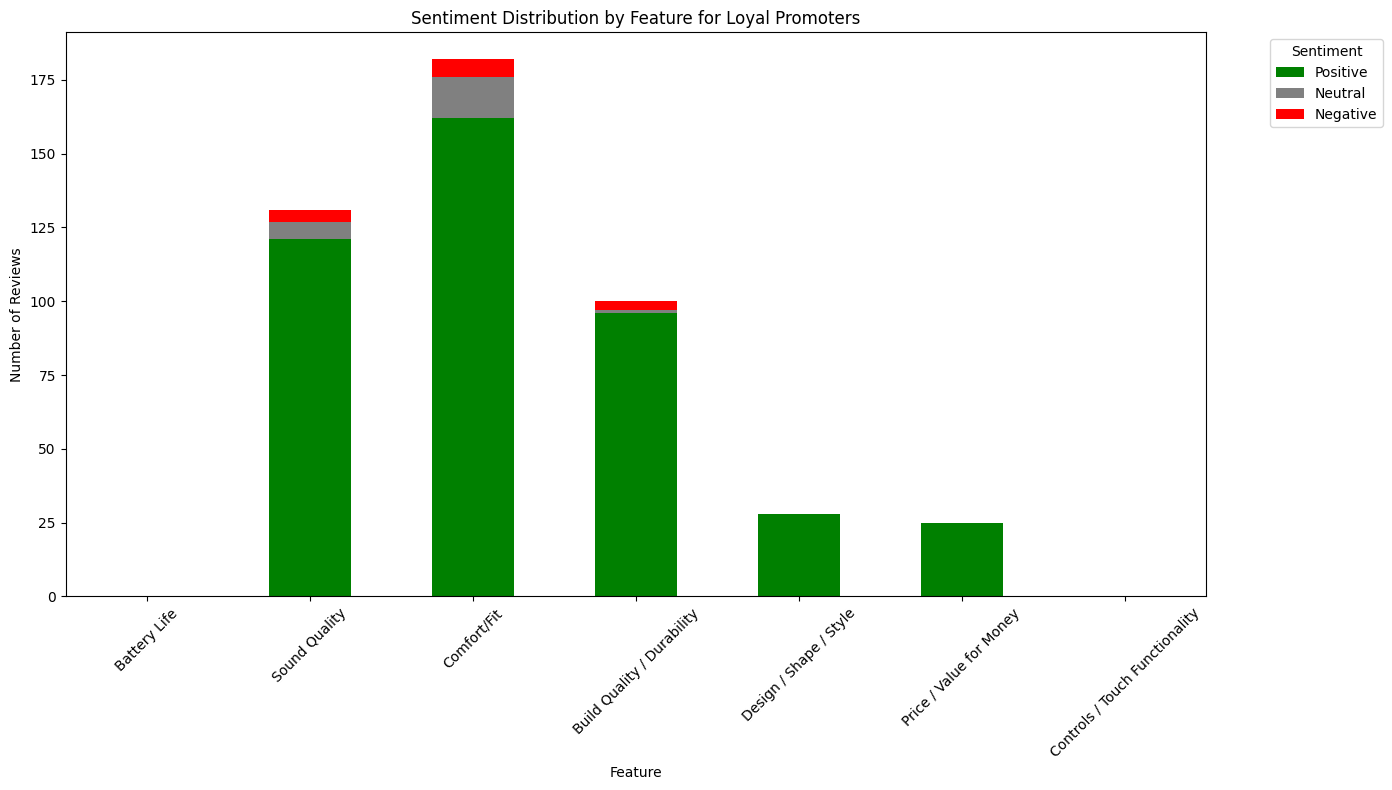

C:\Users\Divy\AppData\Local\Temp\ipykernel_45468\3272634122.py:104: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




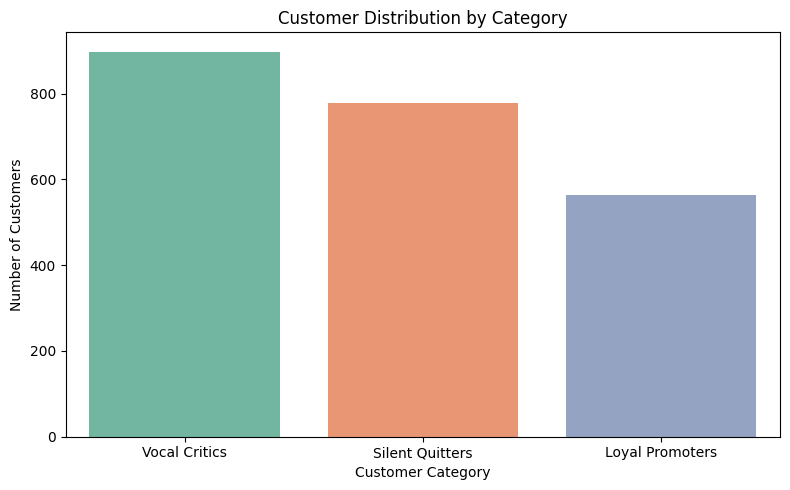

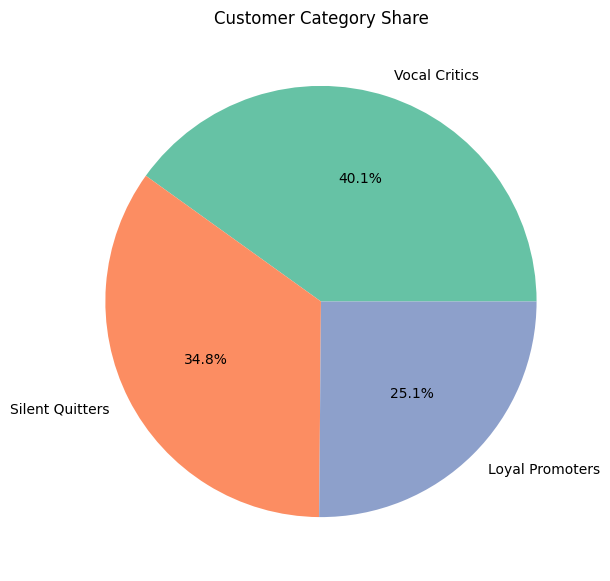


📊 Customer category counts:
 customer_category
Vocal Critics      898
Silent Quitters    779
Loyal Promoters    563
Name: count, dtype: int64

✅ Analysis Complete! CSV file updated with customer scores.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import re

# Step 1: Load data
file_path = r"D:\datathone_project\aba_output_with_scores.csv"
df = pd.read_csv(file_path)

# Step 2: Convert timestamp
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(float) / 1000, unit='s')
except Exception as e:
    print(f"Error converting timestamp: {e}")

# Step 3: Define emotion detection function
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=False)

def detect_emotion(text):
    try:
        return classifier(text[:512])[0]['label']
    except Exception as e:
        print(f"Error on text: {text[:50]}... -> {e}")
        return "neutral"

df['emotion'] = df['cleaned_text'].astype(str).apply(detect_emotion)

# Step 4: Map emotions and sentiments to scores
emotion_map = {'sadness': 1, 'neutral': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

def map_sentiment_score(star_rating):
    if 1.0 <= star_rating < 2.5:
        return 1  # Negative
    elif 2.5 <= star_rating < 3.5:
        return 2  # Neutral
    elif 3.5 <= star_rating <= 5.0:
        return 3  # Positive
    else:
        return 0  # Invalid or missing

df['emotion_score'] = df['emotion'].map(emotion_map).fillna(0)
df['sentiment_score'] = df['vader_star_rating'].apply(map_sentiment_score)
df['customer_score'] = df['emotion_score'] + df['sentiment_score']

# Step 5: Categorize customers
categories = ['Vocal Critics', 'Silent Quitters', 'Loyal Promoters']
df['customer_category'] = pd.cut(df['customer_score'], bins=[0, 3, 5, 8], labels=categories, include_lowest=True)

# Step 6: Aspect Keyword Mapping
aspect_keywords = {
    1: ('Battery Life', ['battery', 'charge', 'charging','battery life','long battery']),
    2: ('Sound Quality', ['sound', 'audio', 'bass', 'treble']),
    3: ('Comfort/Fit', ['fit', 'comfort', 'comfortable', 'ear']),
    4: ('Build Quality / Durability', ['build', 'durable', 'durability', 'broke', 'quality']),
    5: ('Design / Shape / Style', ['design', 'shape', 'style', 'look', 'appearance']),
    6: ('Price / Value for Money', ['price', 'cost', 'value', 'expensive', 'cheap']),
    7: ('Controls / Touch Functionality', ['controls', 'buttons', 'touch', 'tap','finger touch','pad'])
}

def extract_features(row):
    features = []
    for num in str(row).replace(' ', '').split(','):
        try:
            features.append(aspect_keywords.get(int(num), ("Unknown", []))[0])
        except ValueError:
            pass
    return features

df['features_list'] = df['Feature_Number'].apply(extract_features)

# Step 7: Plotting for Each Customer Category
for category in categories:
    category_df = df[df['customer_category'] == category]
    feature_sentiment_counts = {key[0]: {'Positive': 0, 'Neutral': 0, 'Negative': 0} for key in aspect_keywords.values()}
    for idx, row in category_df.iterrows():
        features = row['features_list']
        sentiment = map_sentiment_score(row['vader_star_rating'])
        for feature in features:
            if sentiment == 3:
                feature_sentiment_counts[feature]['Positive'] += 1
            elif sentiment == 2:
                feature_sentiment_counts[feature]['Neutral'] += 1
            elif sentiment == 1:
                feature_sentiment_counts[feature]['Negative'] += 1

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(feature_sentiment_counts).T
    plot_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['green', 'grey', 'red'])
    plt.title(f"Sentiment Distribution by Feature for {category}")
    plt.xlabel("Feature")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Step 8: Visualize Overall Customer Category Distribution

# Bar Chart
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='customer_category', palette='Set2', order=categories)
plt.title('Customer Distribution by Category')
plt.xlabel('Customer Category')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

# Pie Chart (Optional)
category_counts = df['customer_category'].value_counts().reindex(categories)
plt.figure(figsize=(7, 7))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Customer Category Share')
plt.show()

# Print raw counts
print("\n📊 Customer category counts:\n", df['customer_category'].value_counts())

print("\n✅ Analysis Complete! CSV file updated with customer scores.")



🔍 Analyzing Feature Mentions for Category: Silent Quitters


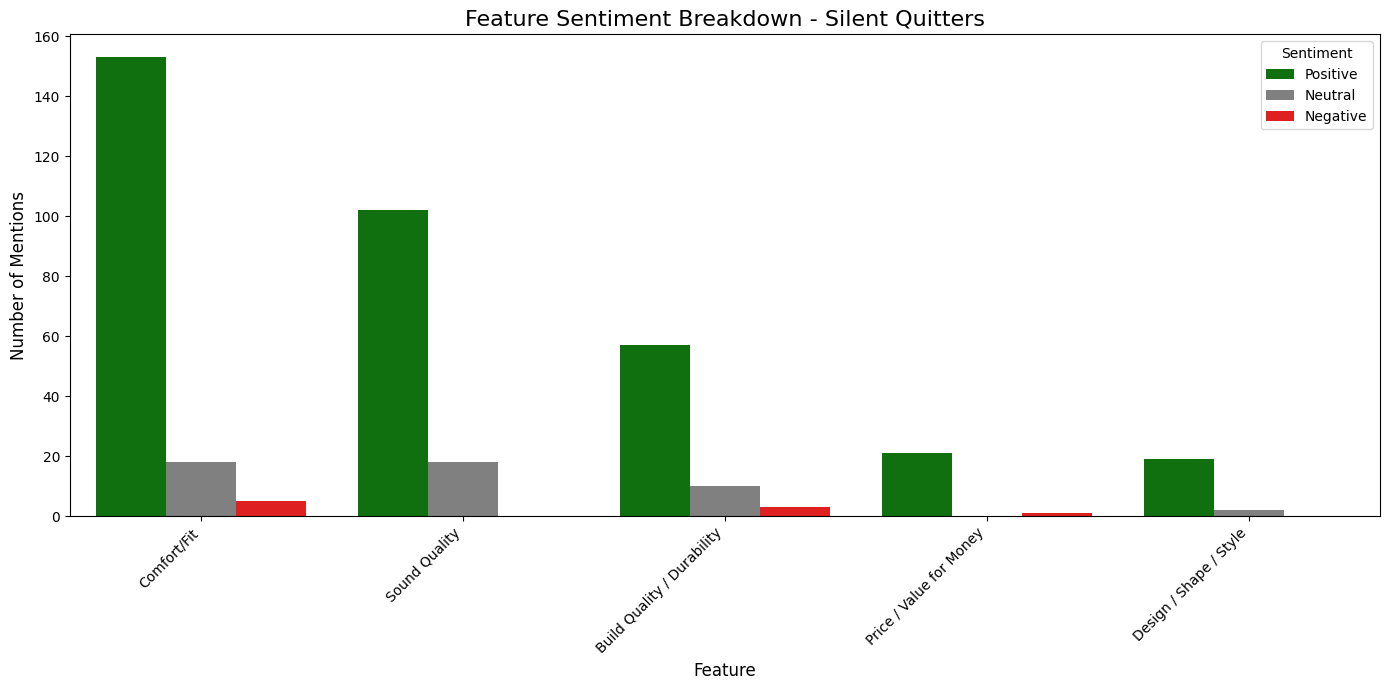


🔍 Analyzing Feature Mentions for Category: Loyal Promoters


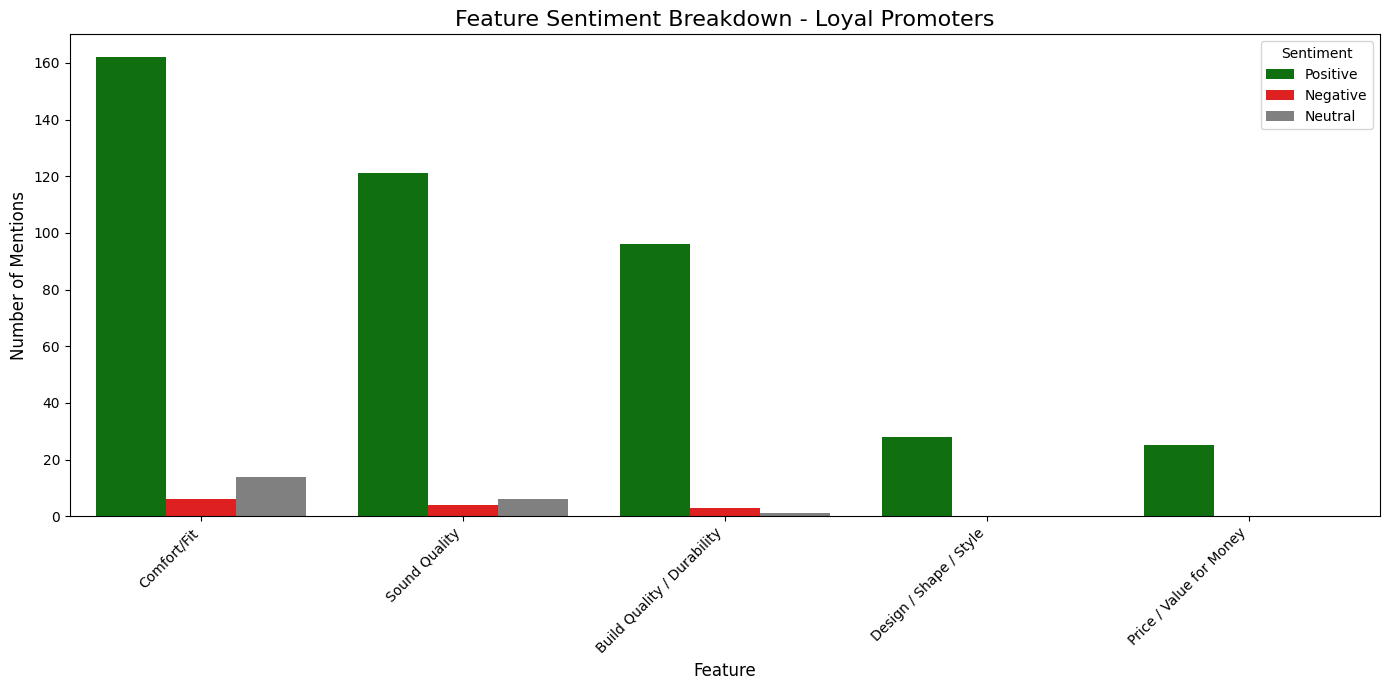


🔍 Analyzing Feature Mentions for Category: Vocal Critics


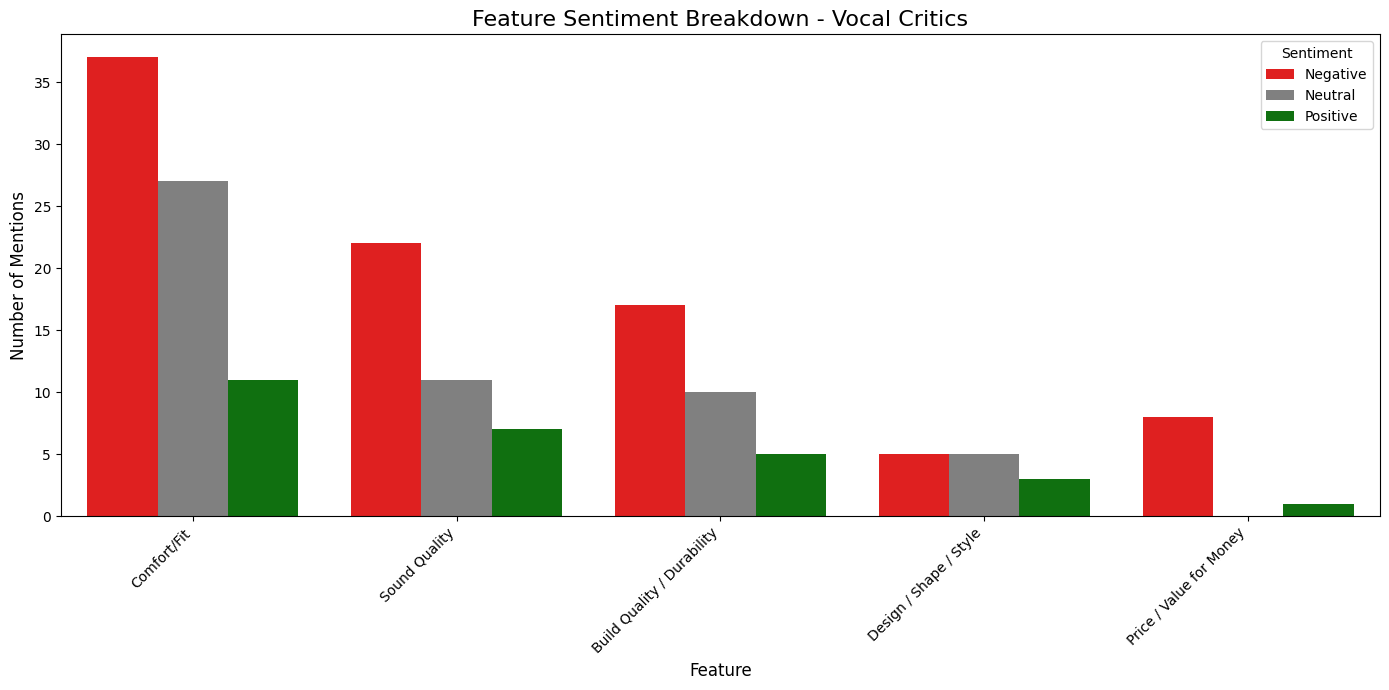

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your sentiment mapping function (replace with actual logic)
def map_sentiment_score(score):
    if score <= 2:
        return 1  # Negative
    elif score == 3:
        return 2  # Neutral
    elif score >= 4:
        return 3  # Positive
    return 0  # Unknown

# Ensure features_list is a list for each row (if not already)
df['features_list'] = df['features_list'].apply(lambda x: x if isinstance(x, list) else [])

# Use actual categories from the data
categories = df['customer_category'].dropna().unique()

# Loop through each category
for category in categories:
    print(f"\n🔍 Analyzing Feature Mentions for Category: {category}")
    category_df = df[df['customer_category'] == category]

    sentiment_data = []

    for idx, row in category_df.iterrows():
        features = row['features_list']
        sentiment = map_sentiment_score(row['vader_star_rating'])
        sentiment_label = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}.get(sentiment, None)

        if sentiment_label:
            for feature in features:
                sentiment_data.append({'Feature': feature, 'Sentiment': sentiment_label})

    # Create a DataFrame for the current category's sentiment-feature data
    sentiment_df = pd.DataFrame(sentiment_data)

    if not sentiment_df.empty:
        plt.figure(figsize=(14, 7))
        sns.countplot(
            data=sentiment_df,
            x='Feature',
            hue='Sentiment',
            palette={'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'},
            order=sentiment_df['Feature'].value_counts().index
        )
        plt.title(f'Feature Sentiment Breakdown - {category}', fontsize=16)
        plt.xlabel('Feature', fontsize=12)
        plt.ylabel('Number of Mentions', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Sentiment')
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ No feature-sentiment data available to plot for: {category}")
